In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import GridSearchCV_scratch

In [3]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
from imodels import HSTreeClassifier, HSTreeRegressor, HSTreeClassifierCV, HSTreeRegressorCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
#import shap
#from shap.explainers._tree import SingleTree
from tqdm import tqdm
import pickle
from datetime import datetime

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","hs_BiasVarTradeoff_simulation")
today_str = datetime.today().strftime("%Y%m%d")

In [5]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = True

# Recreation of results from hierarchical shrinkage paper

Hierarchical Shrinkage: Improving the accuracy and interpretability of tree-based models <br>
[Link to paper](https://proceedings.mlr.press/v162/agarwal22b.html)


>HS is integrated into the imodels package [imodels](github.com/csinva/imodels) (Singh et al., 2021) with an sklearn compatible API. Experiments for reproducing the results here can be found at [imodels-experiments](github.com/Yu-Group/imodels-experiments)

Unfortunately, not all experiments/ figures of the paper can be found in the aforementioned GitHub repository, therefore some of the charts will not be identical to the paper.

## Simulations for Investigating the Bias-Variance Trade-off (Fig. S1 & S2)

### Define function to create simulation and run experiment

In [6]:
# M = 100
# n_samples = 500
# n_feats = 50
# idx_imp_feat = 10
# vals_lambda = np.arange(45.,101.,5.)
# vals_max_tree_depth = np.arange(1,8)
# vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140]# 200, 300, 400, 500]

In [7]:
def bias_var_lin_simulation(M=100, n_samples=500, n_feats=50, idx_imp_feat=10, vals_lambda = np.arange(45.,101.,5.), vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140], noise="gaussian", interaction=False):

    # Create training data
    X_train = np.random.uniform(0, 1, size=(M, n_samples, n_feats))
    if noise=="gaussian":
        noise = np.random.normal(loc=0., scale=0.1, size=(M, n_samples,))
    else:
        noise = np.random.laplace(loc=0., scale=0.1, size=(M, n_samples,))
        
    if interaction == False:
        y_train = X_train[:,:,:idx_imp_feat].sum(axis=2) + noise
    else:
       y_train = X_train[:,:,:idx_imp_feat].sum(axis=2) + X_train[:,:,0]*X_train[:,:,1] + X_train[:,:,4]*X_train[:,:,5] + X_train[:,:,10]*X_train[:,:,11] + noise

    # Create test data
    X_test = np.random.uniform(0, 1, size=(n_samples, n_feats))
    if interaction == False:
        y_test = X_test[:,:idx_imp_feat].sum(axis=1)
    else:
        y_test = X_test[:,:idx_imp_feat].sum(axis=1) + X_test[:,0]*X_test[:,1] + X_test[:,4]*X_test[:,5] + X_test[:,10]*X_test[:,11]

    #Store results
    y_preds= np.empty((M, len(vals_n_leaves), n_samples))
    y_preds_HS = np.empty((M, len(vals_n_leaves), n_samples))
    y_preds_train= np.empty((M, len(vals_n_leaves), n_samples))
    y_preds_train_HS = np.empty((M, len(vals_n_leaves), n_samples))
    lambdas = np.empty((M, len(vals_n_leaves)))
    bias_squared = np.empty((M, len(vals_n_leaves)))
    bias_squaredHS = np.empty((M, len(vals_n_leaves)))
    mse_scores = np.empty((M, len(vals_n_leaves)))
    mse_scoresHS = np.empty((M, len(vals_n_leaves)))

    for i in tqdm(range(M)):

        for j, n_leaves in enumerate(vals_n_leaves):
            reg_tree_sk = DecisionTreeRegressor(max_leaf_nodes=n_leaves)
            reg_tree_sk.fit(X_train[i,:,:], y_train[i,:])
            y_preds[i,j,:] = reg_tree_sk.predict(X_test)
            y_preds_train[i,j,:] = reg_tree_sk.predict(X_train[i,:,:])

            bias_squared[i,j] = ((y_preds_train[i,j,:] - y_train[i,:])**2).mean()
            mse_scores[i,j] = mean_squared_error(y_test, y_preds[i,j,:])

            reg_tree_im = HSTreeRegressorCV(deepcopy(reg_tree_sk), reg_param_list=vals_lambda, cv=3, scoring="neg_mean_squared_error")
            reg_tree_im.fit(X_train[i,:,:], y_train[i,:])
            y_preds_HS[i,j,:] = reg_tree_im.predict(X_test)
            y_preds_train_HS[i,j,:] = reg_tree_im.predict(X_train[i,:,:])

            lambdas[i,j] = reg_tree_im.reg_param

            bias_squaredHS[i,j] = ((y_preds_train_HS[i,j,:] - y_train[i,:])**2).mean()
            mse_scoresHS[i,j] = mean_squared_error(y_test, y_preds_HS[i,j,:])

    return {"X_train":X_train, 
            "y_train":y_train, 
            "X_test":X_test, 
            "y_test":y_test, 
            "y_preds_train":y_preds_train, 
            "y_preds_train_HS":y_preds_train_HS, 
            "y_preds": y_preds, 
            "y_preds_HS": y_preds_HS, 
            "lambdas": lambdas, 
            "bias_squared":bias_squared, 
            "bias_squaredHS":bias_squaredHS, 
            "mse_scores":mse_scores, 
            "mse_scoresHS":mse_scoresHS}

In [8]:
# scorer function for scratch gridsearch 

def neg_mse_scratch(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    output_errors = np.sqrt(np.average((y_true - y_pred) ** 2, axis=0))
    return -np.average(output_errors)

In [9]:
#Function for scratch models with tre depth parameter
def bias_var_lin_simulation_tree_depth(M=100, n_samples=500, n_feats=50, idx_imp_feat=10, vals_lambda = np.arange(45.,101.,5.), vals_max_tree_depth = np.arange(1,8), 
                                        predefined_lambdas=None, noise="gaussian", interaction=False, use_scratch_models=False, random_seed=None):

    # Create training data
    X_train = np.random.uniform(0, 1, size=(M, n_samples, n_feats))
    if noise=="gaussian":
        noise = np.random.normal(loc=0., scale=0.1, size=(M, n_samples,))
    else:
        noise = np.random.laplace(loc=0., scale=0.1, size=(M, n_samples,))
        
    if interaction == False:
        y_train = X_train[:,:,:idx_imp_feat].sum(axis=2) + noise
    else:
       y_train = X_train[:,:,:idx_imp_feat].sum(axis=2) + X_train[:,:,0]*X_train[:,:,1] + X_train[:,:,4]*X_train[:,:,5] + X_train[:,:,10]*X_train[:,:,11] + noise

    # Create test data
    X_test = np.random.uniform(0, 1, size=(n_samples, n_feats))
    if interaction == False:
        y_test = X_test[:,:idx_imp_feat].sum(axis=1)
    else:
        y_test = X_test[:,:idx_imp_feat].sum(axis=1) + X_test[:,0]*X_test[:,1] + X_test[:,4]*X_test[:,5] + X_test[:,10]*X_test[:,11]

    #Store results
    y_preds= np.empty((M, len(vals_max_tree_depth), n_samples))
    y_preds_HS = np.empty((M, len(vals_max_tree_depth), n_samples))
    y_preds_train= np.empty((M, len(vals_max_tree_depth), n_samples))
    y_preds_train_HS = np.empty((M, len(vals_max_tree_depth), n_samples))
    lambdas = np.empty((M, len(vals_max_tree_depth)))
    bias_squared = np.empty((M, len(vals_max_tree_depth)))
    bias_squaredHS = np.empty((M, len(vals_max_tree_depth)))
    mse_scores = np.empty((M, len(vals_max_tree_depth)))
    mse_scoresHS = np.empty((M, len(vals_max_tree_depth)))

    for i in tqdm(range(M)):


        for j, depth in enumerate(vals_max_tree_depth):

            if use_scratch_models==False:

                reg_tree_sk = DecisionTreeRegressor(max_depth=depth)
                reg_tree_sk.fit(X_train[i,:,:], y_train[i,:])
                y_preds[i,j,:] = reg_tree_sk.predict(X_test)
                y_preds_train[i,j,:] = reg_tree_sk.predict(X_train[i,:,:])

                bias_squared[i,j] = ((y_preds_train[i,j,:] - y_train[i,:])**2).mean()
                mse_scores[i,j] = mean_squared_error(y_test, y_preds[i,j,:])

                reg_tree_im = HSTreeRegressorCV(deepcopy(reg_tree_sk), reg_param_list=vals_lambda, cv=3, scoring="neg_mean_squared_error")
                reg_tree_im.fit(X_train[i,:,:], y_train[i,:])
                y_preds_HS[i,j,:] = reg_tree_im.predict(X_test)
                y_preds_train_HS[i,j,:] = reg_tree_im.predict(X_train[i,:,:])

                lambdas[i,j] = reg_tree_im.reg_param

                bias_squaredHS[i,j] = ((y_preds_train_HS[i,j,:] - y_train[i,:])**2).mean()
                mse_scoresHS[i,j] = mean_squared_error(y_test, y_preds_HS[i,j,:])
            
            else:
                #makse scorer for neg mse for scratch cross validation
                #neg_mse = make_scorer(mean_squared_error, greater_is_better=True)

                estimator = DecisionTree(treetype="regression", max_depth=depth)
                estimator.fit(X_train[i,:,:], y_train[i,:])
                y_preds[i,j,:] = estimator.predict(X_test)
                y_preds_train[i,j,:] = estimator.predict(X_train[i,:,:])

                bias_squared[i,j] = ((y_preds_train[i,j,:] - y_train[i,:])**2).mean()
                mse_scores[i,j] = mean_squared_error(y_test, y_preds[i,j,:])

                estimatorHS = DecisionTree(treetype="regression", max_depth=depth, HShrinkage=True)
                
                if isinstance(predefined_lambdas, type(None)):
                    # GridSearch unfortunately takes way too long therefore we will preselect the lambda for all 100 trees based on the sklearn results
                    _ = GridSearchCV_scratch(estimatorHS, {"HS_lambda": vals_lambda}, X_train[i,:,:], y_train[i,:], cv=3, scoring_func=neg_mse_scratch)
                else:
                    setattr(estimatorHS, "HS_lambda", predefined_lambdas[j]) # set predefined lambda for this treedepth
                    estimatorHS.fit(X_train[i,:,:], y_train[i,:])
            
                y_preds_HS[i,j,:] = estimatorHS.predict(X_test)
                y_preds_train_HS[i,j,:] = estimatorHS.predict(X_train[i,:,:])

                lambdas[i,j] = estimatorHS.HS_lambda

                bias_squaredHS[i,j] = ((y_preds_train_HS[i,j,:] - y_train[i,:])**2).mean()
                mse_scoresHS[i,j] = mean_squared_error(y_test, y_preds_HS[i,j,:])


    return {"X_train":X_train, 
            "y_train":y_train, 
            "X_test":X_test, 
            "y_test":y_test, 
            "y_preds_train":y_preds_train, 
            "y_preds_train_HS":y_preds_train_HS, 
            "y_preds": y_preds, 
            "y_preds_HS": y_preds_HS, 
            "lambdas": lambdas, 
            "bias_squared":bias_squared, 
            "bias_squaredHS":bias_squaredHS, 
            "mse_scores":mse_scores, 
            "mse_scoresHS":mse_scoresHS}

### Figure S1 (linear model)

#### Using number of leaves as parameter for model complexity (as in the original HS paper)

In [195]:
gaus_sim_result_dict = bias_var_lin_simulation(noise="gaussian", interaction=False)

100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


In [ ]:
with open(f'{data_path}/{today_str}_gaus_linmodel.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [208]:
#Laplace
lap_sim_result_dict = bias_var_lin_simulation(noise="laplace", interaction=False)

100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


In [209]:
with open(f'{data_path}/{today_str}_lap_linmodel.pickle', 'wb') as handle:
    pickle.dump(lap_sim_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

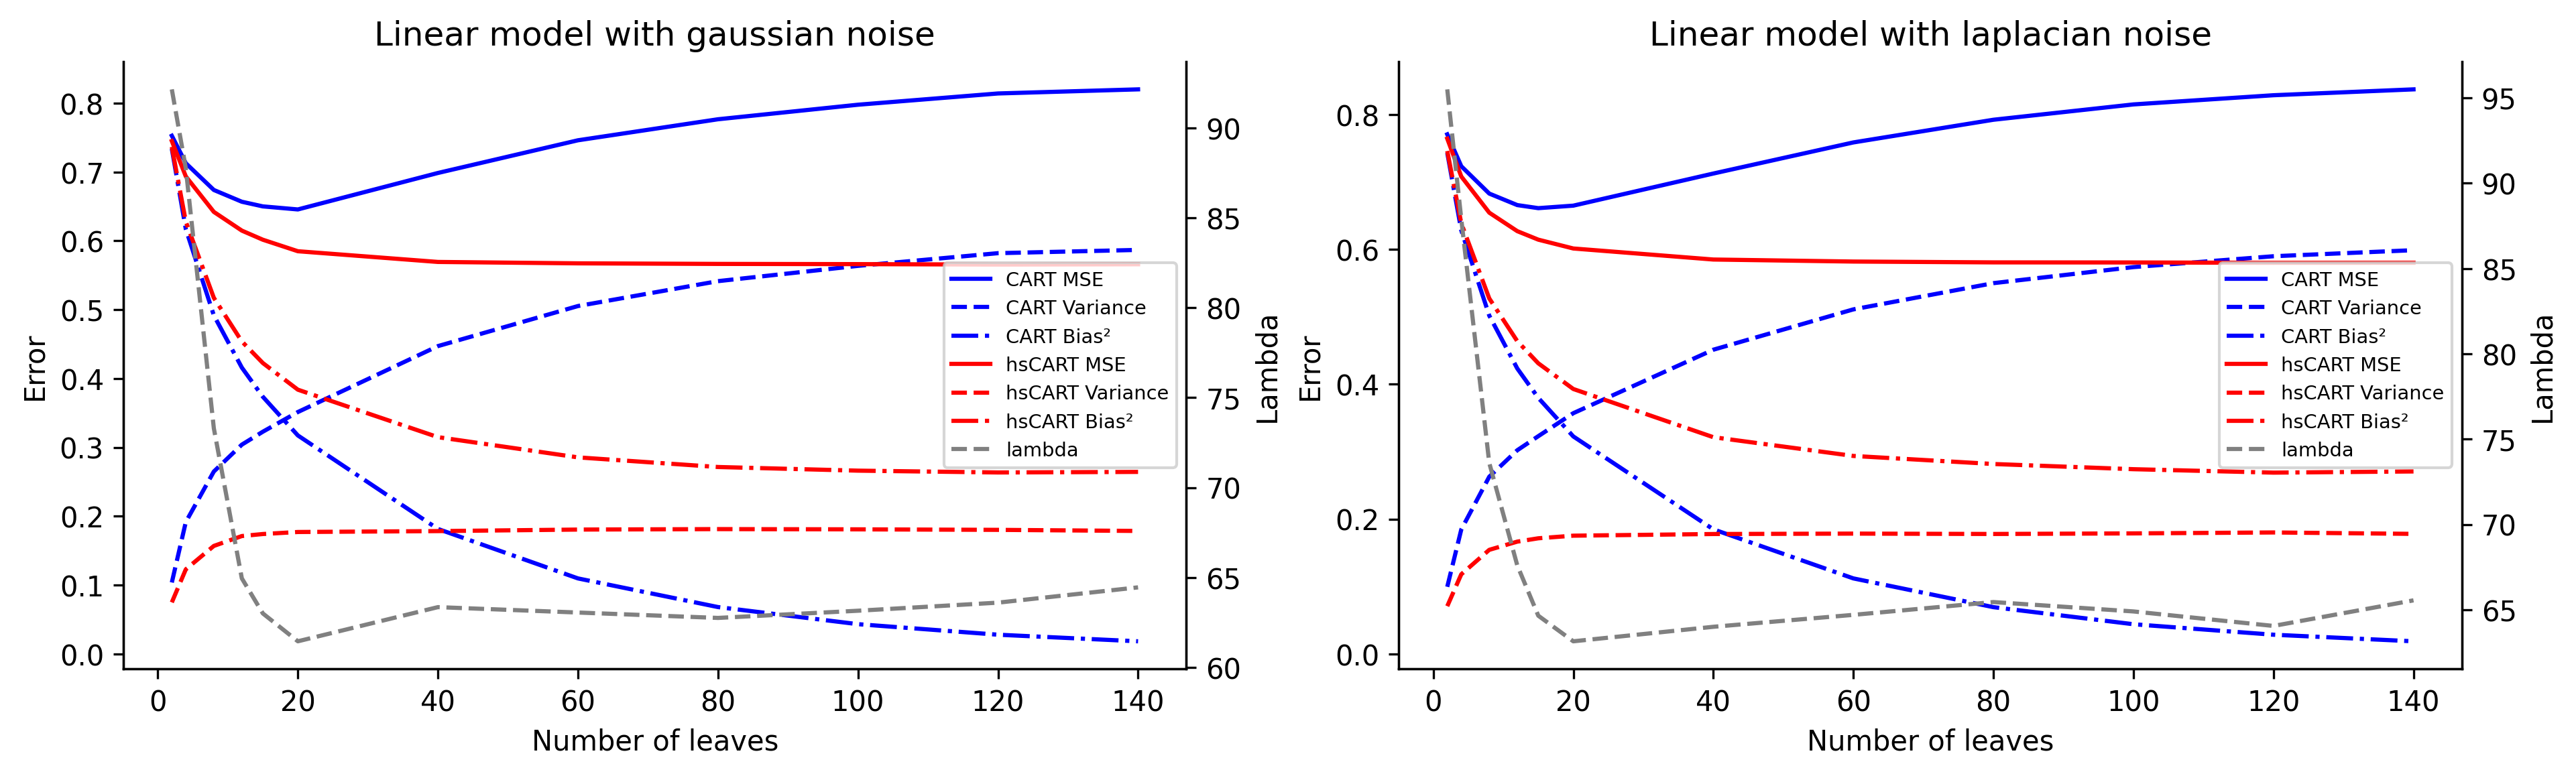

In [214]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140]

#Plot Gaussian
lns1 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_n_leaves, gaus_sim_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Number of leaves")

ax[0].set_title("Linear model with gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_n_leaves, lap_sim_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Number of leaves")

ax[1].set_title("Linear model with laplacian noise");

#### Using max_tree_depth as degree of model complexity

##### First with sklearn and imodels

In [265]:
gaus_sim_treedep_sk = bias_var_lin_simulation_tree_depth(noise="gaussian", interaction=False, use_scratch_models=False, random_seed=None)
lap_sim_treedep_sk = bias_var_lin_simulation_tree_depth(noise="laplace", interaction=False, use_scratch_models=False, random_seed=None)

100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


In [266]:
with open(f'{data_path}/{today_str}_gaus_linmodel_treedep_sk.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_treedep_sk, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{data_path}/{today_str}_lap_linmodel_treedep_sk.pickle', 'wb') as handle:
    pickle.dump(lap_sim_treedep_sk, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open(f'{data_path}/20221102_gaus_linmodel_treedep_sk.pickle', 'rb') as handle:
    gaus_sim_treedep_sk=pickle.load(handle)

with open(f'{data_path}/20221102_lap_linmodel_treedep_sk.pickle', 'rb') as handle:
    lap_sim_treedep_sk=pickle.load(handle)

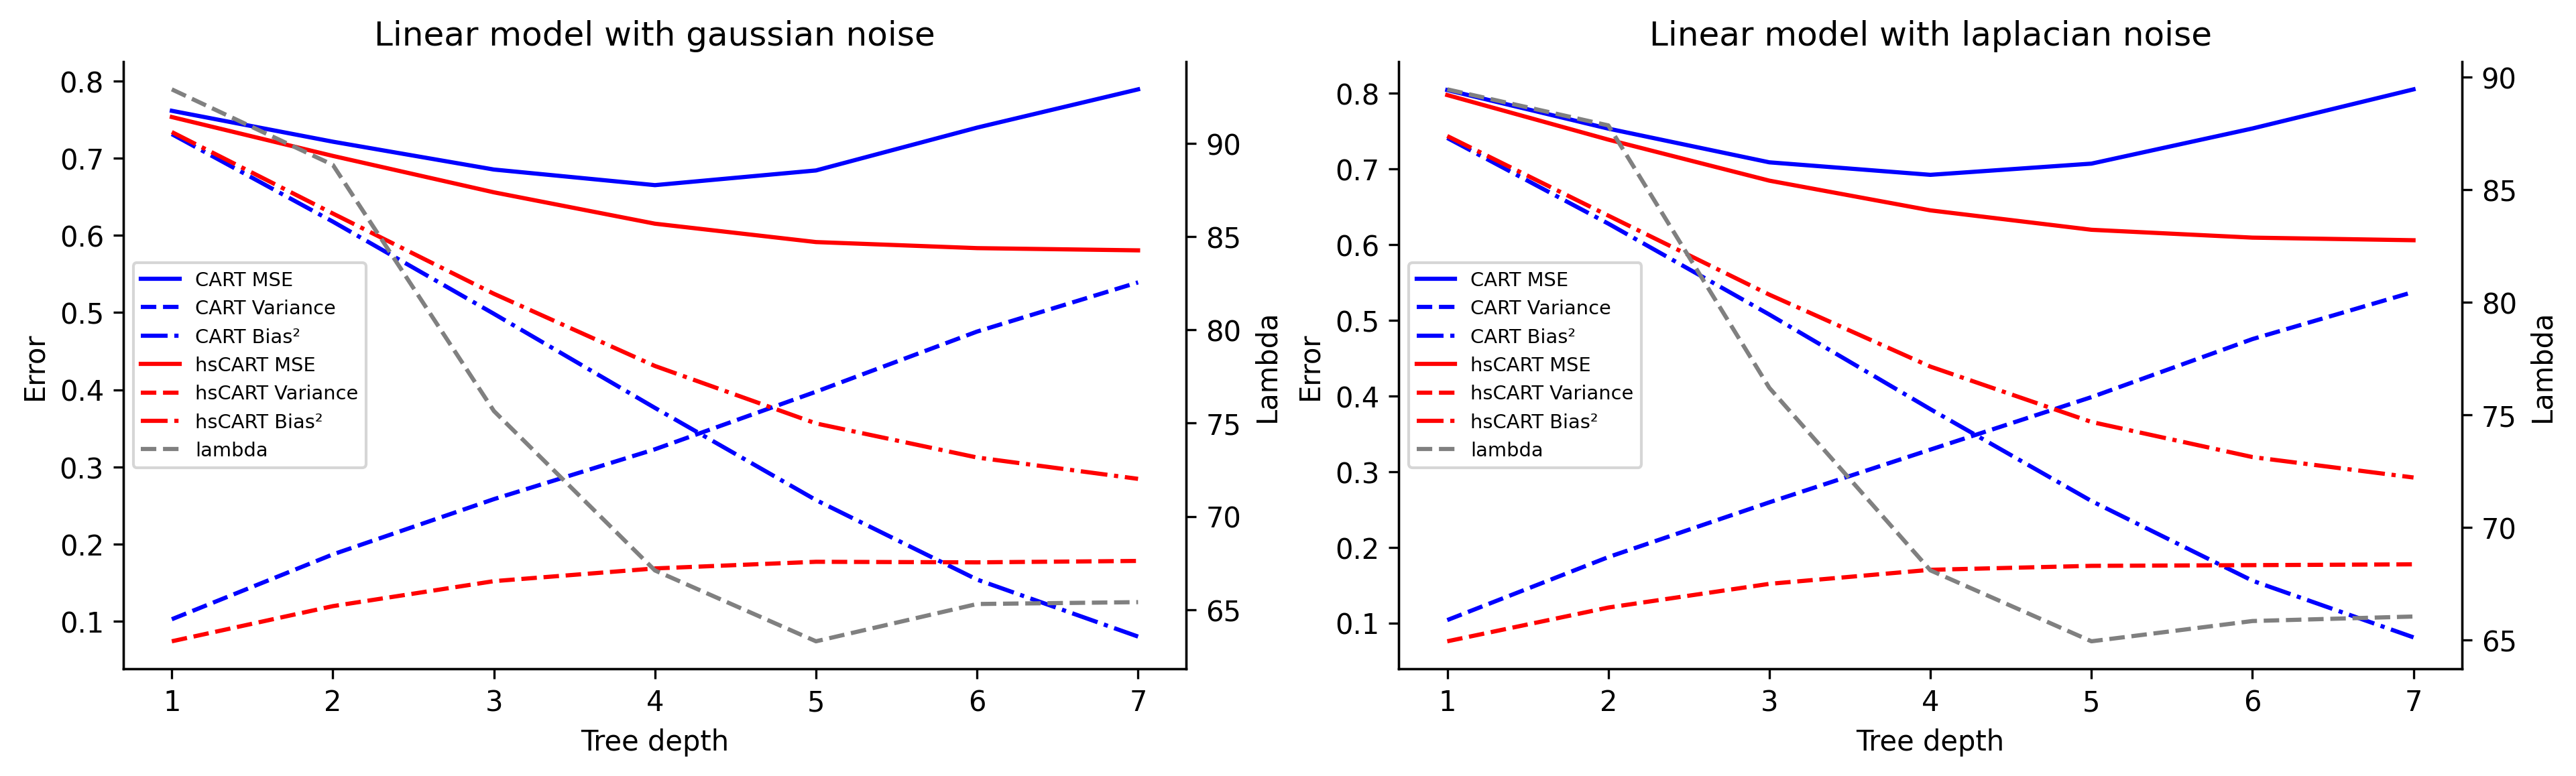

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_max_tree_depth = np.arange(1,8)

#Plot Gaussian
lns1 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_sk["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_sk["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_sk["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_sk["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_sk["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_sk["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_max_tree_depth, gaus_sim_treedep_sk["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Tree depth")

ax[0].set_title("Linear model with gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_sk["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_sk["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_sk["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_sk["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_sk["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_sk["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_max_tree_depth, lap_sim_treedep_sk["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Tree depth")

ax[1].set_title("Linear model with laplacian noise");

##### Now with scratch models

GridSearch unfortunately takes way too long therefore we will preselect the lambda for all 100 trees for each tree depth based on the sklearn results

In [13]:
gaus_lambda_scr = gaus_sim_treedep_sk["lambdas"].mean(axis=0)
lap_lambda_scr = lap_sim_treedep_sk["lambdas"].mean(axis=0)

In [14]:
gaus_sim_treedep_scr = bias_var_lin_simulation_tree_depth(M=100, predefined_lambdas=gaus_lambda_scr, noise="gaussian", interaction=False, use_scratch_models=True, random_seed=None)

100%|██████████| 100/100 [5:48:59<00:00, 209.40s/it] 


In [15]:
with open(f'{data_path}/{today_str}_gaus_linmodel_treedep_scr.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_treedep_scr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
lap_sim_treedep_scr = bias_var_lin_simulation_tree_depth(M=100, predefined_lambdas = lap_lambda_scr, noise="laplace", interaction=False, use_scratch_models=True, random_seed=None)

100%|██████████| 100/100 [5:49:57<00:00, 209.97s/it] 


In [18]:
with open(f'{data_path}/{today_str}_lap_linmodel_treedep_scr.pickle', 'wb') as handle:
    pickle.dump(lap_sim_treedep_scr, handle, protocol=pickle.HIGHEST_PROTOCOL)

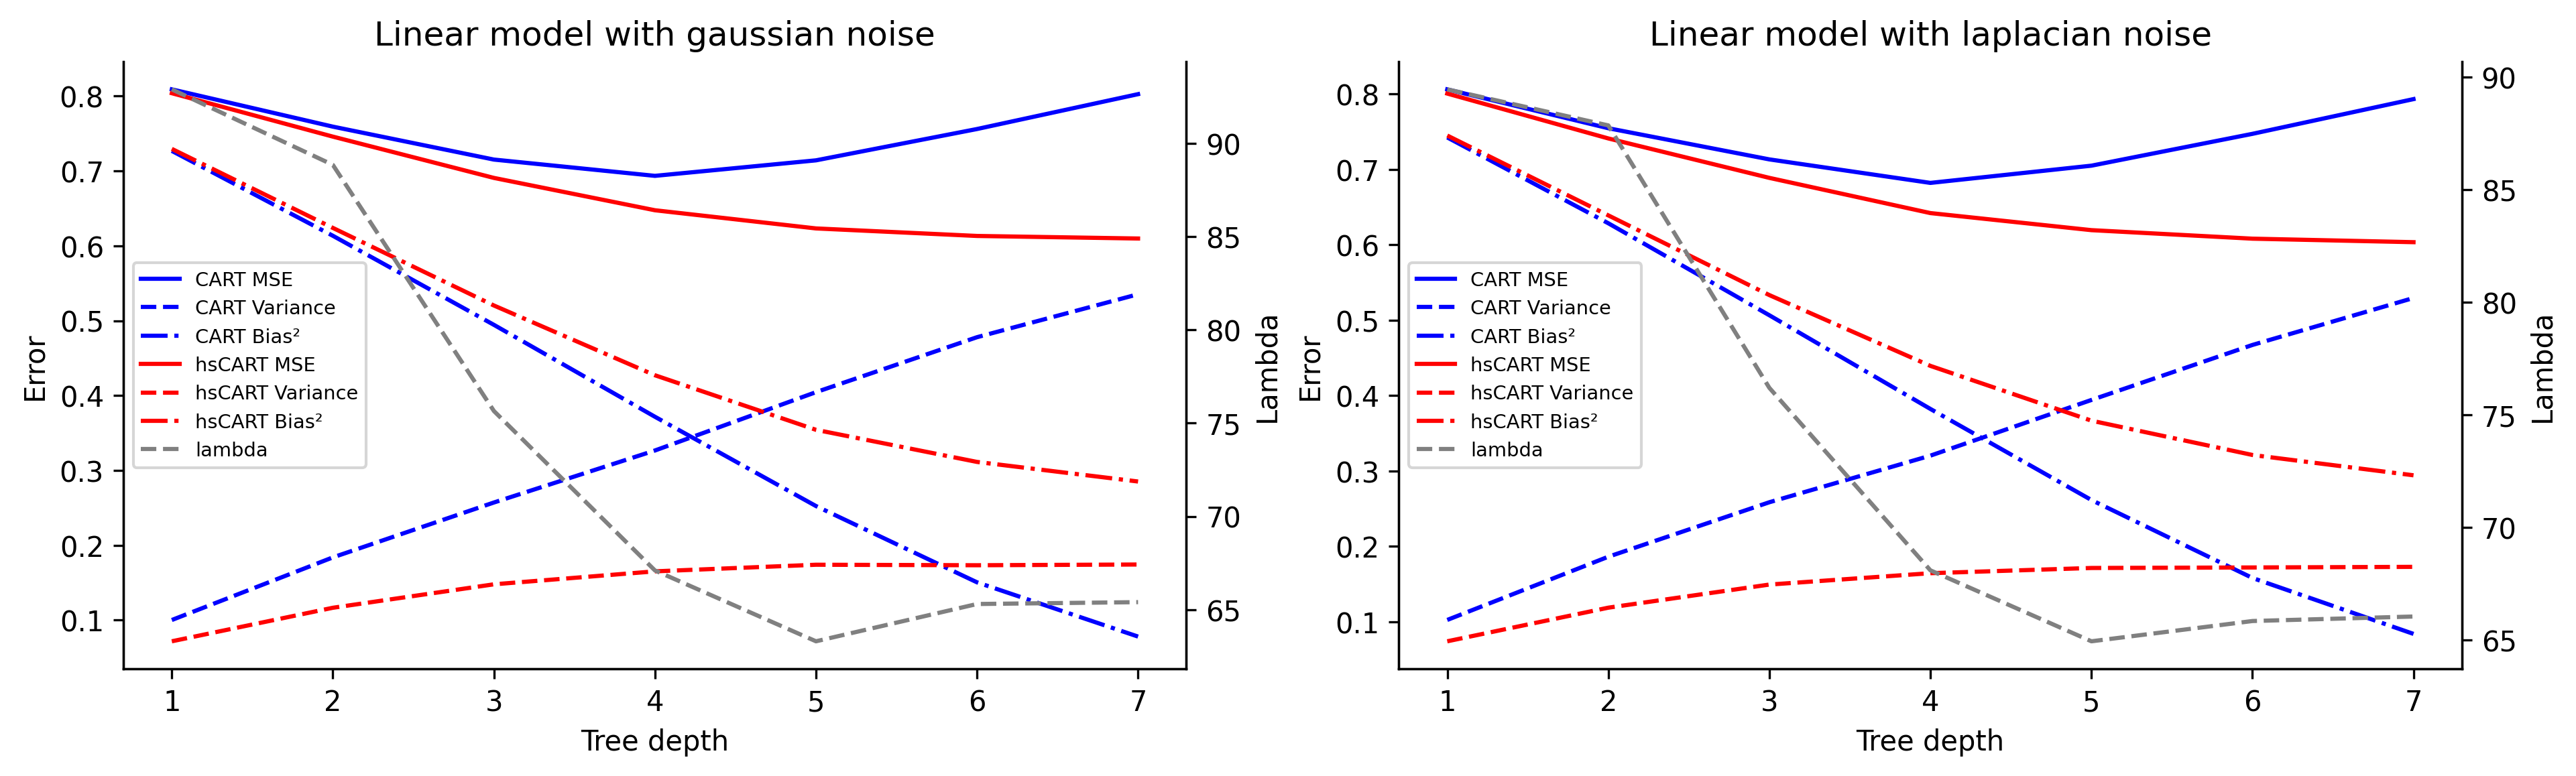

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_max_tree_depth = np.arange(1,8)

#Plot Gaussian
lns1 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_scr["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_scr["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_scr["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_scr["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_scr["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_max_tree_depth, gaus_sim_treedep_scr["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_max_tree_depth, gaus_sim_treedep_scr["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Tree depth")

ax[0].set_title("Linear model with gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_scr["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_scr["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_scr["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_scr["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_scr["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_max_tree_depth, lap_sim_treedep_scr["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_max_tree_depth, lap_sim_treedep_scr["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Tree depth")

ax[1].set_title("Linear model with laplacian noise");

### Figure S2 (linear model with pairwise interaction)

#### Using number of leaves as parameter for model complexity (as in original HS paper)

In [220]:
gaus_sim_inter_result_dict = bias_var_lin_simulation(noise="gaussian", interaction=True)

100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


In [221]:
with open(f'{data_path}/{today_str}_gaus_linmodel_interaction.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_inter_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [222]:
#Laplace
lap_sim_inter_result_dict = bias_var_lin_simulation(noise="laplace", interaction=True)

100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


In [223]:
with open(f'{data_path}/{today_str}_lap_linmodel_interaction.pickle', 'wb') as handle:
    pickle.dump(lap_sim_inter_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

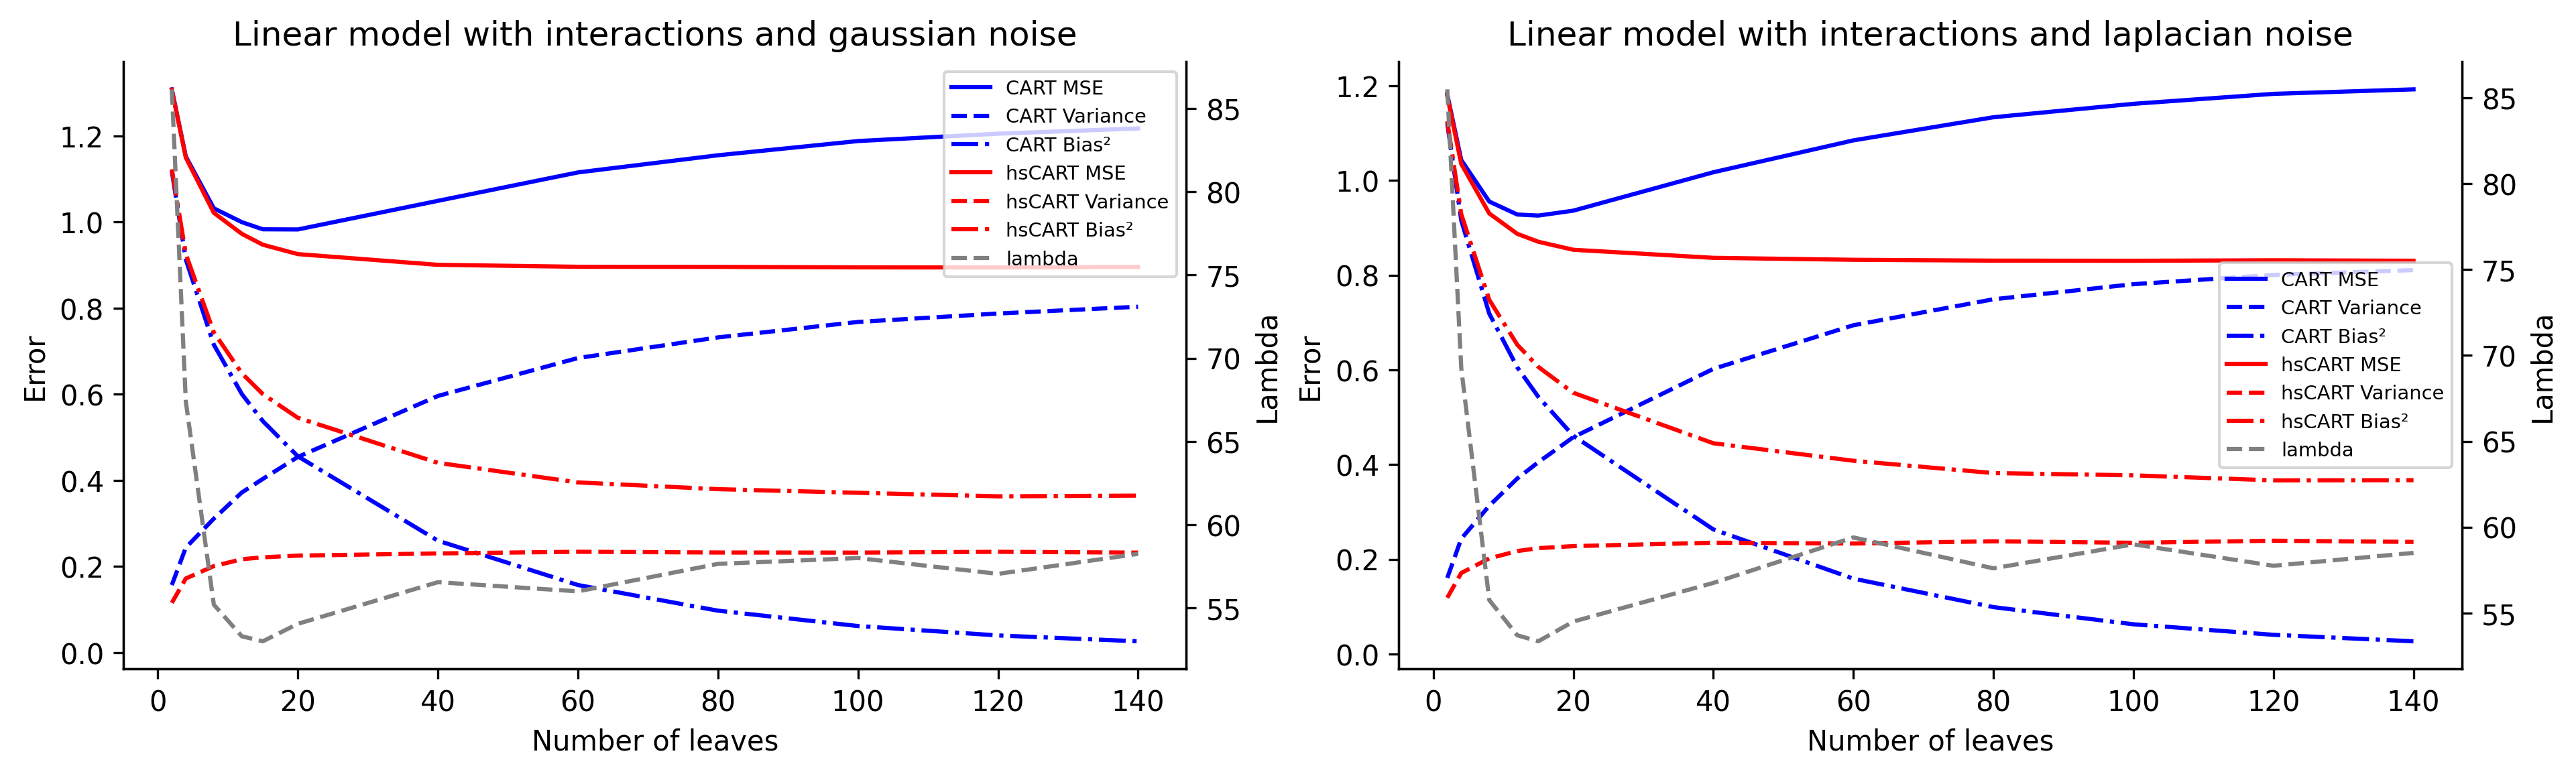

In [224]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140]

#Plot Gaussian
lns1 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_n_leaves, gaus_sim_inter_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Number of leaves")

ax[0].set_title("Linear model with interactions and gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_n_leaves, lap_sim_inter_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Number of leaves")

ax[1].set_title("Linear model with interactions and laplacian noise");

#### Using max_tree_depth as degree of model complexity

##### First with sklearn and imodels

In [ ]:
gaus_sim_inter_treedep_sk = bias_var_lin_simulation_tree_depth(noise="gaussian", interaction=True, use_scratch_models=False, random_seed=None)
lap_sim_inter_treedep_sk = bias_var_lin_simulation_tree_depth(noise="laplace", interaction=True, use_scratch_models=False, random_seed=None)

100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


In [ ]:
with open(f'{data_path}/{today_str}_gaus_linmodel_interaction_treedep_sk.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_inter_treedep_sk, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{data_path}/{today_str}_lap_linmodel_interaction_treedep_sk.pickle', 'wb') as handle:
    pickle.dump(lap_sim_inter_treedep_sk, handle, protocol=pickle.HIGHEST_PROTOCOL)

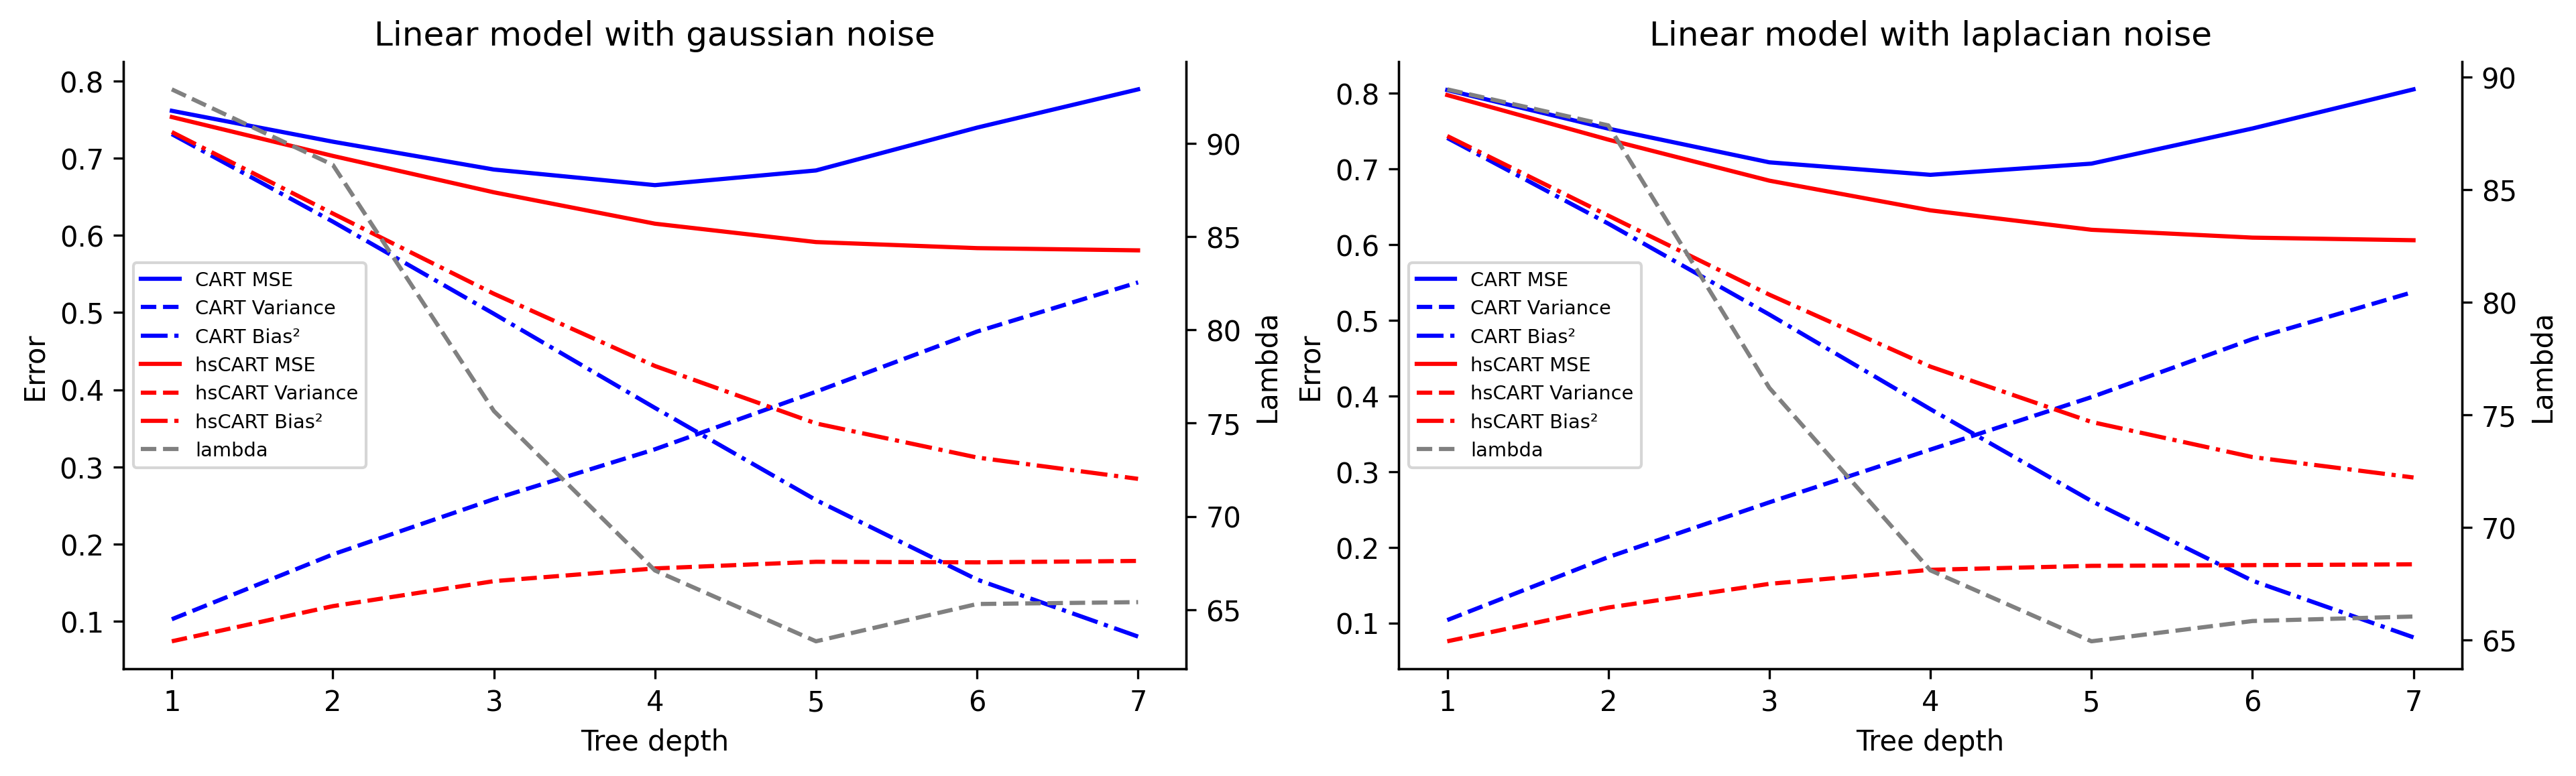

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_max_tree_depth = np.arange(1,8)

#Plot Gaussian
lns1 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_max_tree_depth, gaus_sim_inter_treedep_sk["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Tree depth")

ax[0].set_title("Linear model with gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_max_tree_depth, lap_sim_inter_treedep_sk["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Tree depth")

ax[1].set_title("Linear model with laplacian noise");

##### Now with scratch models

GridSearch unfortunately takes way too long therefore we will preselect the lambda for all 100 trees for each tree depth based on the sklearn results

In [ ]:
gaus_lambda_scr = gaus_sim_inter_treedep_sk["lambdas"].mean(axis=0)
lap_lambda_scr = lap_sim_inter_treedep_sk["lambdas"].mean(axis=0)

In [ ]:
gaus_sim_inter_treedep_scr = bias_var_lin_simulation_tree_depth(M=100, predefined_lambdas=gaus_lambda_scr, noise="gaussian", interaction=True, use_scratch_models=True, random_seed=None)
lap_sim_inter_treedep_scr = bias_var_lin_simulation_tree_depth(M=100, predefined_lambdas = lap_lambda_scr, noise="laplace", interaction=True, use_scratch_models=True, random_seed=None)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
with open(f'{data_path}/{today_str}_gaus_linmodel_interaction_treedep_scr.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_inter_treedep_scr, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{data_path}/{today_str}_lap_linmodel_interaction_treedep_scr.pickle', 'wb') as handle:
    pickle.dump(lap_sim_inter_treedep_scr, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'lap_sim_treedep_scr' is not defined

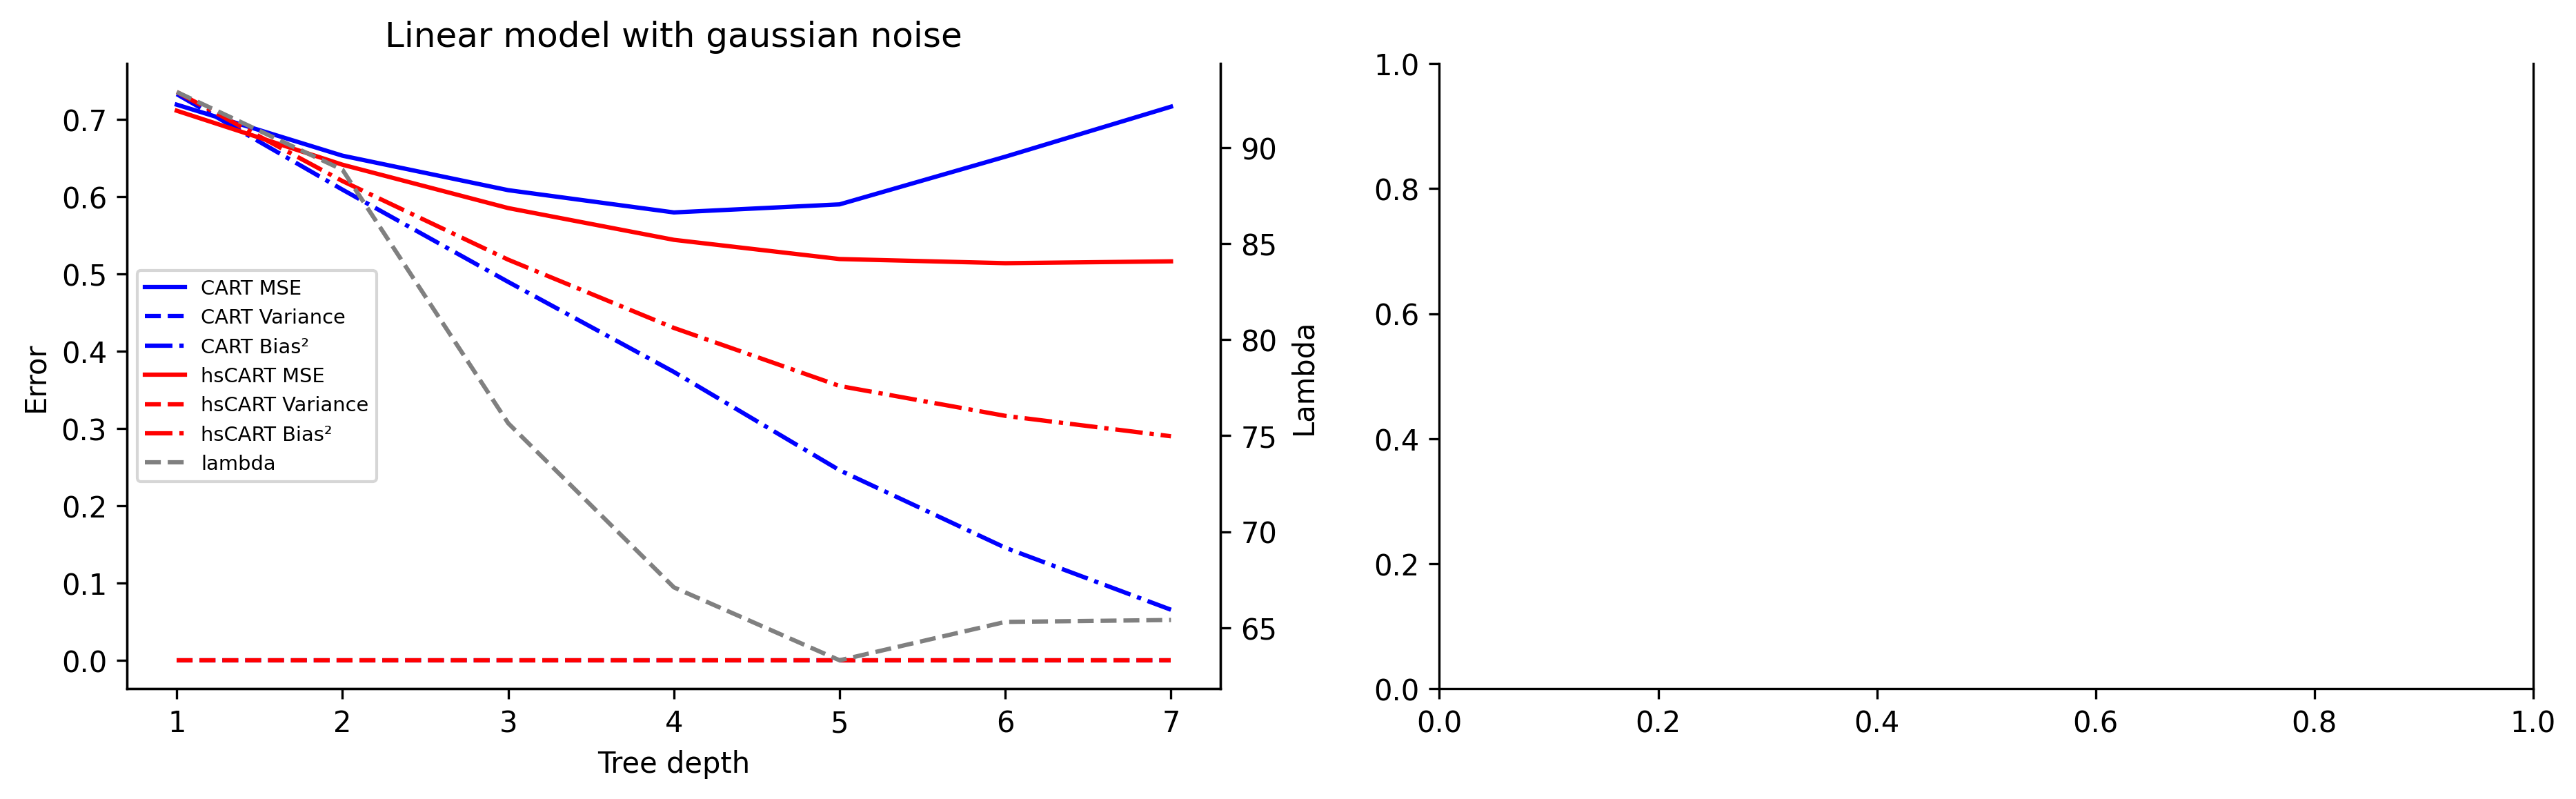

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_max_tree_depth = np.arange(1,8)

#Plot Gaussian
lns1 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_max_tree_depth, gaus_sim_inter_treedep_scr["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Tree depth")

ax[0].set_title("Linear model with gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_max_tree_depth, lap_sim_inter_treedep_scr["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Tree depth")

ax[1].set_title("Linear model with laplacian noise");